In [1]:
import pandas as pd
from datetime import datetime, timedelta
import xarray as xr

# Set up location and time point

In [2]:
# some point in North Pacific Ocean
target_longitude = -170.2
target_latitude = 40.4
# how large should the region around the target location be for averaging values
region_padding_degrees = 0.0
# how many days back do we look for averaging values
days_back = 10
# average salinity/temp values in the region (yes/no)
average_location = False

# current time
time_point = datetime.now()
# another point in time
#time_point = datetime(2023, 12, 25)

# Retrieve data from Copernicus API

In [3]:
import copernicusmarine

def format_data_points(current_datetime, days_back = 10):
    current_date_str = current_datetime.strftime("%Y-%m-%d")
    earlier_datetime = current_datetime - timedelta(days=days_back)
    earlier_date_str = earlier_datetime.strftime("%Y-%m-%d")
    return earlier_date_str, current_date_str

def copernicus_salinity_temp(target_longitude, region_padding_degrees, time_point, average_location = False, days_back = 10):
    start_time, end_time = format_data_points(time_point)
    
    measurement_ds = copernicusmarine.open_dataset(
        dataset_id = "cmems_mod_glo_phy-so_anfc_0.083deg_P1D-m",
        minimum_longitude = target_longitude-region_padding_degrees,
        maximum_longitude = target_longitude+region_padding_degrees,
        minimum_latitude = target_latitude-region_padding_degrees,
        maximum_latitude = target_latitude+region_padding_degrees,
        start_datetime = start_time,
        end_datetime = end_time,
        variables = ["sea_water_salinity"],
        # USER DATA ARE KEPT FOR HISTORY REASONS, CAN BE REPLACED WITH SOMETHING MEANINGFUL
        username='test',
        password='test'
    )
    
    temp_ds = copernicusmarine.open_dataset(
        dataset_id = "cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m",
        minimum_longitude = target_longitude-region_padding_degrees,
        maximum_longitude = target_longitude+region_padding_degrees,
        minimum_latitude = target_latitude-region_padding_degrees,
        maximum_latitude = target_latitude+region_padding_degrees,
        start_datetime = start_time,
        end_datetime = end_time,
        variables = ["sea_water_potential_temperature"],
        # USER DATA ARE KEPT FOR HISTORY REASONS, CAN BE REPLACED WITH SOMETHING MEANINGFUL
        username='test',
        password='test'
    )

    measurement_ds['thetao'] = temp_ds['thetao']

    if average_location:
        measurement_ds = measurement_ds.mean(dim=['time', 'latitude', 'longitude'])
    else:
        measurement_ds = measurement_ds.mean(dim=['time'])

    return measurement_ds

In [4]:
measurement_ds = copernicus_salinity_temp(target_longitude, region_padding_degrees, time_point, 
                                          average_location = average_location, days_back = days_back)
measurement_ds

INFO - 2024-05-16T15:41:18Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-05-16T15:41:18Z - Dataset part was not specified, the first one was selected: "default"
WARNING - 2024-05-16T15:41:18Z - The dataset cmems_mod_glo_phy-so_anfc_0.083deg_P1D-m, version '202211', will be retired on the 2024-07-26T00:00:00.000Z. After this date, it will no longer be available on the toolbox.
INFO - 2024-05-16T15:41:20Z - Service was not specified, the default one was selected: "arco-time-series"
INFO - 2024-05-16T15:41:22Z - Dataset version was not specified, the latest one was selected: "202211"
INFO - 2024-05-16T15:41:22Z - Dataset part was not specified, the first one was selected: "default"
WARNING - 2024-05-16T15:41:22Z - The dataset cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m, version '202211', will be retired on the 2024-07-26T00:00:00.000Z. After this date, it will no longer be available on the toolbox.
INFO - 2024-05-16T15:41:23Z - Service was not sp

<xarray.Dataset> Size: 608B
Dimensions:    (depth: 50, latitude: 1, longitude: 1)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 4B 40.42
  * longitude  (longitude) float32 4B -170.2
Data variables:
    so         (depth, latitude, longitude) float32 200B 34.0 34.0 ... 34.69 nan
    thetao     (depth, latitude, longitude) float32 200B 12.14 12.14 ... nan

# Compute sound speed

In [5]:
import gsw

#https://www.teos-10.org/pubs/gsw/html/gsw_sound_speed_t_exact.html
#https://teos-10.github.io/GSW-Python/gsw_flat.html
def compute_sound_speed_gsw(measurement_ds):
    potential_temps = measurement_ds['thetao']
    latitudes = measurement_ds['latitude']
    longitudes = measurement_ds['longitude']
    depths = measurement_ds['depth']
    salinities = measurement_ds['so']
    pressures = gsw.p_from_z(-depths, latitudes)
    CT_temps = gsw.CT_from_pt(salinities, potential_temps)
    temps = gsw.t_from_CT(salinities, CT_temps, pressures)
    absolute_salinities = gsw.SA_from_SP(salinities, pressures, longitudes, latitudes)
    measurement_ds['temp'] = temps
    measurement_ds['GSW_sound_speed'] = gsw.sound_speed_t_exact(absolute_salinities, temps, pressures)
    return measurement_ds

def Mackenzie_formula(temp, so, depth):
    return 1448.96 + 4.591 * temp - 0.05304 * (temp ** 2) + 2.374e-4 * (temp ** 3) + 1.34 * (so - 35) + 0.0163 * depth

def compute_sound_speed_Mackenzie(measurement_ds):
    potential_temps = measurement_ds['thetao']
    depths = measurement_ds['depth']
    salinities = measurement_ds['so']
    latitudes = measurement_ds['latitude']
    pressures = gsw.p_from_z(-depths, latitudes)
    CT_temps = gsw.CT_from_pt(salinities, potential_temps)
    temps = gsw.t_from_CT(salinities, CT_temps, pressures)
    measurement_ds['temp'] = temps
    measurement_ds['Mackenzie_sound_speed'] = Mackenzie_formula(temps, salinities, depths)
    return measurement_ds

In [6]:
compute_sound_speed_Mackenzie(measurement_ds)

<xarray.Dataset> Size: 1kB
Dimensions:                (depth: 50, latitude: 1, longitude: 1)
Coordinates:
  * depth                  (depth) float32 200B 0.494 1.541 ... 5.728e+03
  * latitude               (latitude) float32 4B 40.42
  * longitude              (longitude) float32 4B -170.2
Data variables:
    so                     (depth, latitude, longitude) float32 200B 34.0 ......
    thetao                 (depth, latitude, longitude) float32 200B 12.14 .....
    temp                   (depth, latitude, longitude) float64 400B 12.14 .....
    Mackenzie_sound_speed  (depth, latitude, longitude) float64 400B 1.496e+0...

In [7]:
compute_sound_speed_gsw(measurement_ds)

<xarray.Dataset> Size: 2kB
Dimensions:                (depth: 50, latitude: 1, longitude: 1)
Coordinates:
  * depth                  (depth) float32 200B 0.494 1.541 ... 5.728e+03
  * latitude               (latitude) float32 4B 40.42
  * longitude              (longitude) float32 4B -170.2
Data variables:
    so                     (depth, latitude, longitude) float32 200B 34.0 ......
    thetao                 (depth, latitude, longitude) float32 200B 12.14 .....
    temp                   (depth, latitude, longitude) float64 400B 12.14 .....
    Mackenzie_sound_speed  (depth, latitude, longitude) float64 400B 1.496e+0...
    GSW_sound_speed        (depth, latitude, longitude) float64 400B 1.496e+0...

In [8]:
measurement_ds.to_dataframe().reset_index()

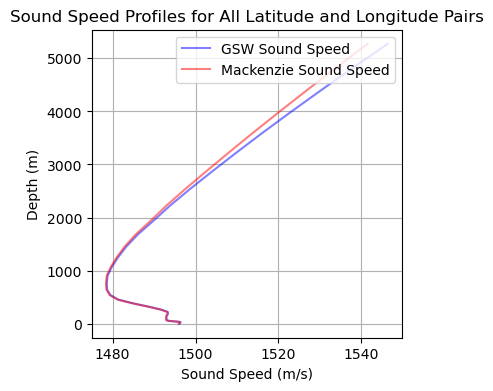

In [15]:
import matplotlib.pyplot as plt
 
def visualize_SSP(data):
    plt.figure(figsize=(4, 4))
    
    grouped_data = data.groupby(['latitude', 'longitude'])
    
    # Plot each group
    for (lat, lon), group in grouped_data:
        # Plot GSW sound speed profile
        plt.plot(group['GSW_sound_speed'], group['depth'], label=f'GSW Sound Speed ({lat}, {lon})', color='b', alpha=0.5)
        
        # Plot Mackenzie sound speed profile
        plt.plot(group['Mackenzie_sound_speed'], group['depth'], label=f'Mackenzie Sound Speed ({lat}, {lon})', color='r', alpha=0.5)
    
    # Invert y-axis to show depth increasing downwards
    #plt.gca().invert_yaxis()
    
    # Labels and title
    plt.xlabel('Sound Speed (m/s)')
    plt.ylabel('Depth (m)')
    plt.title('Sound Speed Profiles for All Latitude and Longitude Pairs')
    plt.grid(True)
    
    # Create a custom legend to distinguish between GSW and Mackenzie sound speed
    handles = [
        plt.Line2D([0], [0], color='b', alpha=0.5, label='GSW Sound Speed'),
        plt.Line2D([0], [0], color='r', alpha=0.5, label='Mackenzie Sound Speed')
    ]
    plt.legend(handles=handles, loc='upper right')
    
    # Show the plot
    plt.show()

visualize_SSP(measurement_ds.to_dataframe().reset_index())